In [1]:
import os
import time
import arxiv
import cgi
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from sklearn.base import BaseEstimator
from collections import Counter
from gensim.models import CoherenceModel,  LdaMulticore
import pyLDAvis.gensim
import nltk
from typing import List
from gensim import models, corpora
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel
#nltk.download("punkt")
#nltk.download("wordnet")
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
#COMMENTS EINLESEN
df_com = pd.read_csv("uberdrivers_comments_output_unfiltered_scores_time.csv")
df_com['created_utc'] = pd.to_datetime(df_com['created_utc'], unit='s')
df_com = df_com[(df_com['body'].str.split().str.len() >= 15) & (df_com['score'] >= 3)]
df_com = df_com[~(df_com['body'] == '[deleted]')]
df_com = df_com.drop(["author","created_utc"], axis=1)
df_com = df_com.dropna(how='any')
df_com = df_com.reset_index(drop=True)
df_com.rename(columns={'body': 'text'}, inplace=True)
df_com.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255656 entries, 0 to 255655
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    255656 non-null  object
 1   score   255656 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.9+ MB


In [3]:
#SUBREDDITS EINLESEN
#Für die Supmissions wird Titel und selftext zusammengeführt. 
df_subm = pd.read_csv("uberdrivers_submissions_output_unfiltered_scores_time.csv")
df_subm['text'] = df_subm['title'] + ' ' + df_subm['selftext']
df_subm['created_utc'] = pd.to_datetime(df_subm['created_utc'], unit='s')
df_subm = df_subm[df_subm['text'].str.split().str.len() >= 5]
df_subm = df_subm.drop(['selftext', 'title', 'author',"created_utc"], axis=1)
df_subm = df_subm.dropna(how='any')
df_subm = df_subm.reset_index(drop=True)
df_subm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79145 entries, 0 to 79144
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   79145 non-null  int64 
 1   text    79145 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [4]:
df_both = pd.concat([df_com, df_subm], ignore_index=True)
df_both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334801 entries, 0 to 334800
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    334801 non-null  object
 1   score   334801 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.1+ MB


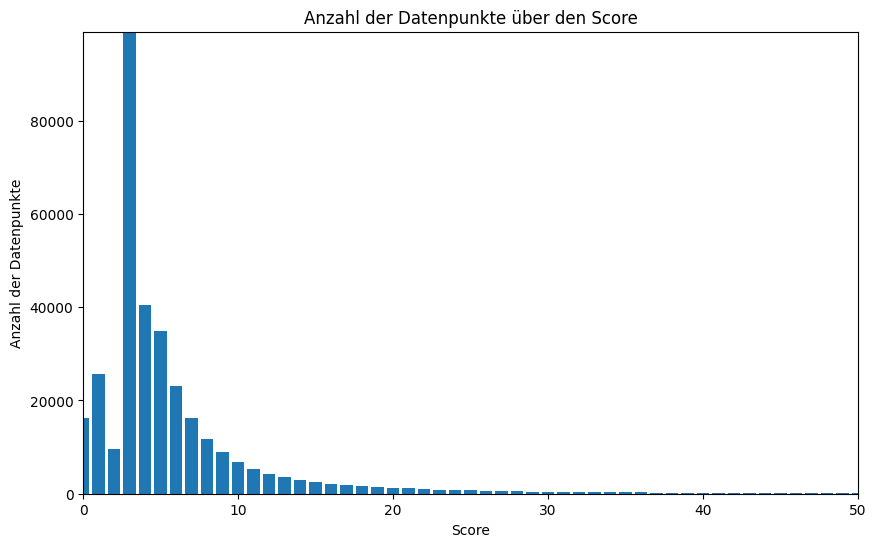

In [5]:
score_counts = df_both.groupby('score').size()
# Plot der Anzahl der Datenpunkte über den Score
plt.figure(figsize=(10, 6))
plt.bar(score_counts.index, score_counts.values)
plt.xlabel('Score')
plt.ylabel('Anzahl der Datenpunkte')
plt.title('Anzahl der Datenpunkte über den Score')
plt.xlim(0, 50)  # Setze die x-Achse von 0 bis 50
plt.ylim(0, score_counts.max() + 5) 
plt.show()

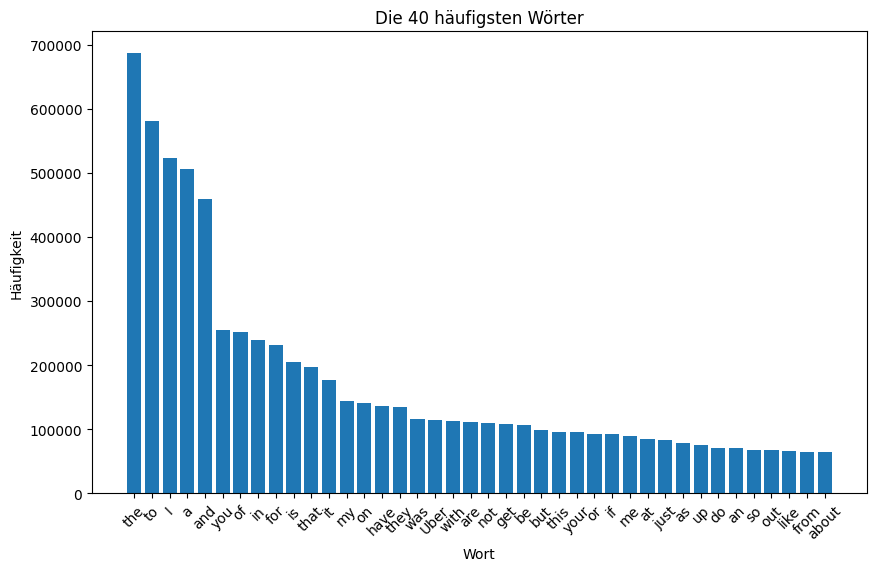

In [6]:
def plot_top_words(texts, num_words=40):
    all_text = ' '.join(texts)
    word_counts = Counter(all_text.split())
    top_words = word_counts.most_common(num_words)

    words = [word for word, count in top_words]
    counts = [count for word, count in top_words]

    # Plot der häufigsten Wörter
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xlabel('Wort')
    plt.ylabel('Häufigkeit')
    plt.title(f'Die {num_words} häufigsten Wörter')
    plt.xticks(rotation=45)
    plt.show()

plot_top_words(df_both["text"], 40)

In [7]:
#Set Up NLTK und Spacy

nlp = spacy.load('en_core_web_sm')

try:
    from nltk.corpus import stopwords 
    
except: 
    import nltk 
    nltk.downlaod("stopwords")

finally:
    from nltk.corpus import stopwords 

stops = set(stopwords.words('english'))
#print(stops)

In [8]:
shortcomings = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"you've": "you have",
"idk" : "I do not know",
"fyi" : "for your information",
"omg" : "oh my god" 
}

In [9]:
#CLEANING
def convert_to_lowercase(text: str) -> str:
    return text.lower()

def regex(text: str) -> str:
   
    text = re.sub(r'\S*@\S*\s?', '', text) #EMAIL
    text = re.sub(r'\s+', ' ', text) #Mehrface sapces zu einem
    text = re.sub(r"\'", '', text)#Anführungszeichen 
    text = re.sub(r'http[s]?://\S+', '', text) #URL
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text) #SMILEYS
    text = re.sub(r'\d+', '', text) #Zahlen
    text = re.sub(r'\b\w\b', '', text) #Einzelne buchstaben  
    hashtags = re.findall(r'#\w+', text) #Hashtags in hashtags
    text += ' '.join(hashtags)   #hastags in text 
    return text

def lemmatize(text: str) -> str:
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    return " ".join(lemmatized_words)

def remove_stopwords(text: str, sw: List[str] = stopwords.words("english")) -> str:   
    additional_sw = ["uber","ubers","driver","drivers","get"]
    sw = sw + additional_sw
    text_list = text.split()
    text_list = [word for word in text_list if word not in sw]
    return " ".join(text_list)

def remove_punctuation(text: str, punct: str = string.punctuation) -> str:  
    cleaned_text = "".join([char for char in text if char not in punct])
    return cleaned_text

def unicode(text: str) -> str:
    return unidecode.unidecode(text)

def clean(text: str) -> str:
    text = unicode(text)
    text = remove_shortcomings(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = regex(text)
    return text

def remove_shortcomings(text):
    text = text.lower()
    
    text = text.split()
    new_text = []
    
    for word in text:
        if word in shortcomings:
            new_text.append(shortcomings[word])
        else:
            new_text.append(word)
            
    text = " ".join(new_text)
    
    return text

In [10]:
df_both["text"] = df_both["text"].apply(lambda x : clean(x)) 

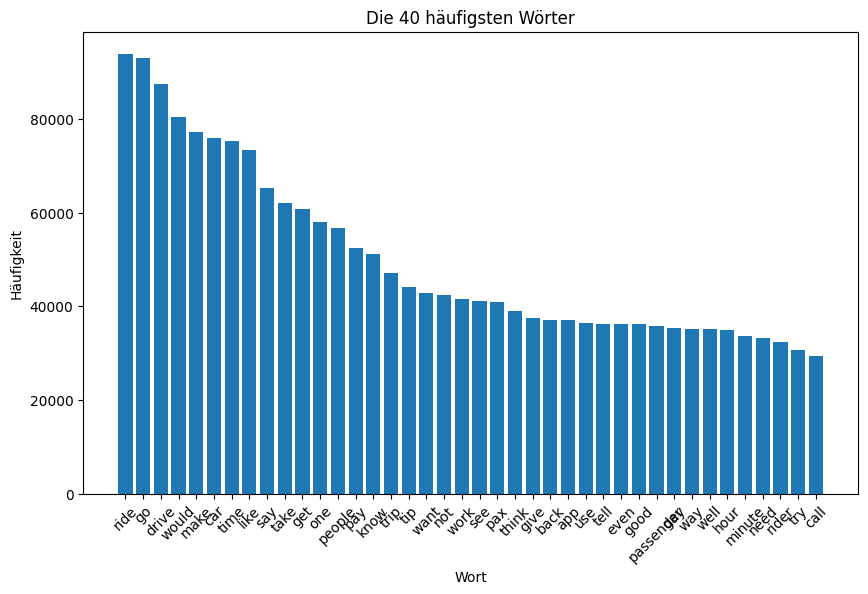

In [11]:
plot_top_words(df_both["text"],40) #Potentielle Stopwörter

In [12]:
sample_texts = df_both['text'].sample(n=5, random_state=42)

for text in sample_texts:
    print(text)
    print('---')

read room oh boston red sox hat well today definitely yankee fan bronx
---
sure understand last sentence try refactore yes get message check everything look legit persongrad student exist website send valid university oregon qualtric sure survey measure seem arrive conclusion even see datum mention attend grad school lot work
---
decent gas mileage passat unless up ante fuel surge gas come back  range
---
sure enough actual policy document click go nothing legally enforceable interesting question far liability go
---
go  card least  day ago still have not show online long take  ve put money scence
---


In [13]:
#Vector Space Model 
article_summaries = df_both['text'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

# create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

2023-07-10 07:09:00,375 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-07-10 07:09:00,679 : INFO : adding document #10000 to Dictionary<15505 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:00,951 : INFO : adding document #20000 to Dictionary<21818 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:01,224 : INFO : adding document #30000 to Dictionary<26993 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:01,483 : INFO : adding document #40000 to Dictionary<31565 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:01,746 : INFO : adding document #50000 to Dictionary<35185 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:02,016 : INFO : adding document #60000 to Dictionary<38877 unique tokens: ['around', 'average', 'awesome', 'buck', 'clear']...>
2023-07-10 07:09:02,292 : INFO : adding doc

In [21]:
# Compute coherence score
anzahl_topics = []
coherence_score = []

for i in range(10,18):
    lda_model = LdaMulticore(corpus=corpus, 
                            id2word=dictionary,
                            iterations=50,
                            num_topics=i,
                            passes=10,
                            workers=11)
    print(i)
    # Instantiate topic coherence model
    coherence_model_lda = CoherenceModel(model=lda_model, texts=article_summaries, dictionary=dictionary, coherence='c_v')
    
    # Get topic coherence score
    coherence_lda = coherence_model_lda.get_coherence()
    anzahl_topics.append(i)
    print(coherence_lda)
    coherence_score.append(coherence_lda)

2023-07-10 09:37:59,039 : INFO : using symmetric alpha at 0.1
2023-07-10 09:37:59,040 : INFO : using symmetric eta at 0.1
2023-07-10 09:37:59,058 : INFO : using serial LDA version on this node
2023-07-10 09:37:59,152 : INFO : running online LDA training, 10 topics, 10 passes over the supplied corpus of 334801 documents, updating every 22000 documents, evaluating every ~220000 documents, iterating 50x with a convergence threshold of 0.001000
2023-07-10 09:37:59,154 : INFO : training LDA model using 11 processes
2023-07-10 09:37:59,828 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:37:59,844 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:37:59,847 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:37:59,849 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/33480

10


2023-07-10 09:40:59,867 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,868 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,870 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,870 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,872 : INFO : accumulator serialized
2023-07-10 09:40:59,866 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,889 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,875 : INFO : accumulator serialized
2023-07-10 09:40:59,895 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,908 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,901 : INFO : accumulator serialized
2023-07-10 09:40:59,907 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,930 : INFO : serializing accumulator to return to master...
2023-07-10 09:40:59,918 : INFO :

0.5388145217641254


2023-07-10 09:41:02,930 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:41:02,947 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:41:02,949 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:41:02,951 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:41:02,953 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:41:02,955 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:41:02,957 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:41:02,959 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

11


2023-07-10 09:43:59,815 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,811 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,820 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,818 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,823 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,824 : INFO : accumulator serialized
2023-07-10 09:43:59,813 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,826 : INFO : accumulator serialized
2023-07-10 09:43:59,824 : INFO : accumulator serialized
2023-07-10 09:43:59,826 : INFO : accumulator serialized
2023-07-10 09:43:59,823 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,832 : INFO : serializing accumulator to return to master...
2023-07-10 09:43:59,835 : INFO : accumulator serialized
2023-07-10 09:43:59,835 : INFO : accumulator serialized
2023-07-10 09:43:59,831 

0.5272046290861175


2023-07-10 09:44:02,113 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:44:02,130 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:44:02,132 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:44:02,134 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:44:02,136 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:44:02,138 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:44:02,140 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:44:02,142 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

12


2023-07-10 09:47:06,872 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,878 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,878 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,882 : INFO : accumulator serialized
2023-07-10 09:47:06,883 : INFO : accumulator serialized
2023-07-10 09:47:06,885 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,887 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,890 : INFO : accumulator serialized
2023-07-10 09:47:06,894 : INFO : accumulator serialized
2023-07-10 09:47:06,890 : INFO : accumulator serialized
2023-07-10 09:47:06,904 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,912 : INFO : accumulator serialized
2023-07-10 09:47:06,926 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,934 : INFO : serializing accumulator to return to master...
2023-07-10 09:47:06,941 

0.5414102019084769


2023-07-10 09:47:09,321 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:47:09,342 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:47:09,345 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:47:09,347 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:47:09,349 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:47:09,351 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:47:09,353 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:47:09,355 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

13


2023-07-10 09:50:24,389 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,397 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,391 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,400 : INFO : accumulator serialized
2023-07-10 09:50:24,394 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,416 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,422 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,427 : INFO : accumulator serialized
2023-07-10 09:50:24,425 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,406 : INFO : accumulator serialized
2023-07-10 09:50:24,427 : INFO : serializing accumulator to return to master...
2023-07-10 09:50:24,428 : INFO : accumulator serialized
2023-07-10 09:50:24,429 : INFO : accumulator serialized
2023-07-10 09:50:24,436 : INFO : serializing accumulator to return to master...


0.5302841725798757


2023-07-10 09:50:26,991 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:50:27,015 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:50:27,018 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:50:27,020 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:50:27,022 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:50:27,025 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:50:27,027 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:50:27,029 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

14


2023-07-10 09:53:19,453 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,458 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,458 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,462 : INFO : accumulator serialized
2023-07-10 09:53:19,456 : INFO : accumulator serialized
2023-07-10 09:53:19,463 : INFO : accumulator serialized
2023-07-10 09:53:19,468 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,474 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,477 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,485 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,487 : INFO : accumulator serialized
2023-07-10 09:53:19,488 : INFO : accumulator serialized
2023-07-10 09:53:19,487 : INFO : serializing accumulator to return to master...
2023-07-10 09:53:19,498 : INFO : serializing accumulator to return to master...


0.5253753454664405


2023-07-10 09:53:21,756 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:53:21,776 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:53:21,778 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:53:21,781 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:53:21,784 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:53:21,787 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:53:21,790 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:53:21,792 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

15


2023-07-10 09:56:09,186 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,188 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,189 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,191 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,193 : INFO : accumulator serialized
2023-07-10 09:56:09,195 : INFO : accumulator serialized
2023-07-10 09:56:09,196 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,198 : INFO : accumulator serialized
2023-07-10 09:56:09,197 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,211 : INFO : accumulator serialized
2023-07-10 09:56:09,208 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,215 : INFO : serializing accumulator to return to master...
2023-07-10 09:56:09,219 : INFO : accumulator serialized
2023-07-10 09:56:09,220 : INFO : serializing accumulator to return to master...


0.5611489913575275


2023-07-10 09:56:11,551 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:56:11,615 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:56:11,618 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:56:11,620 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:56:11,622 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:56:11,624 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:56:11,626 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:56:11,628 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

16


2023-07-10 09:59:04,972 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:04,973 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:04,974 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:04,976 : INFO : accumulator serialized
2023-07-10 09:59:04,976 : INFO : accumulator serialized
2023-07-10 09:59:04,989 : INFO : accumulator serialized
2023-07-10 09:59:04,984 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:04,989 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:04,994 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:05,004 : INFO : accumulator serialized
2023-07-10 09:59:05,002 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:05,009 : INFO : serializing accumulator to return to master...
2023-07-10 09:59:05,000 : INFO : accumulator serialized
2023-07-10 09:59:05,013 : INFO : accumulator serialized
2023-07-10 09:59:05,026 

0.5372860833582802


2023-07-10 09:59:07,408 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 09:59:07,429 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 09:59:07,431 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 09:59:07,433 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/334801, outstanding queue size 4
2023-07-10 09:59:07,435 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/334801, outstanding queue size 5
2023-07-10 09:59:07,437 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/334801, outstanding queue size 6
2023-07-10 09:59:07,439 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/334801, outstanding queue size 7
2023-07-10 09:59:07,441 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/33480

17


2023-07-10 10:02:00,556 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,553 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,559 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,559 : INFO : accumulator serialized
2023-07-10 10:02:00,570 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,573 : INFO : accumulator serialized
2023-07-10 10:02:00,567 : INFO : accumulator serialized
2023-07-10 10:02:00,576 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,577 : INFO : accumulator serialized
2023-07-10 10:02:00,588 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,592 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,584 : INFO : serializing accumulator to return to master...
2023-07-10 10:02:00,595 : INFO : accumulator serialized
2023-07-10 10:02:00,648 : INFO : serializing accumulator to return to master...


0.5311267404685537


In [22]:
topic_coherence = pd.DataFrame({'number_of_topics':anzahl_topics,
                               'coherence_score':coherence_score})

# Print topic_coherence dataframe
topic_coherence 

number_of_topics  coherence_score
0                10         0.538815
1                11         0.527205
2                12         0.541410
3                13         0.530284
4                14         0.525375
5                15         0.561149
6                16         0.537286
7                17         0.531127

In [28]:
data = {'number_of_topics': list(range(2,10)), 'coherence_score': coherence_2_10}
topic_coherence_2_10 = pd.DataFrame(data)

In [34]:
topic_coh_ges = pd.concat([topic_coherence_2_10, topic_coherence], ignore_index=True)

In [33]:
topic_coh_ges

number_of_topics  coherence_score
0                 2         0.532436
1                 3         0.523407
2                 4         0.539833
3                 5         0.536976
4                 6         0.528157
5                 7         0.537687
6                 8         0.538388
7                 9         0.535442
0                10         0.538815
1                11         0.527205
2                12         0.541410
3                13         0.530284
4                14         0.525375
5                15         0.561149
6                16         0.537286
7                17         0.531127

<Axes: xlabel='number_of_topics', ylabel='coherence_score'>

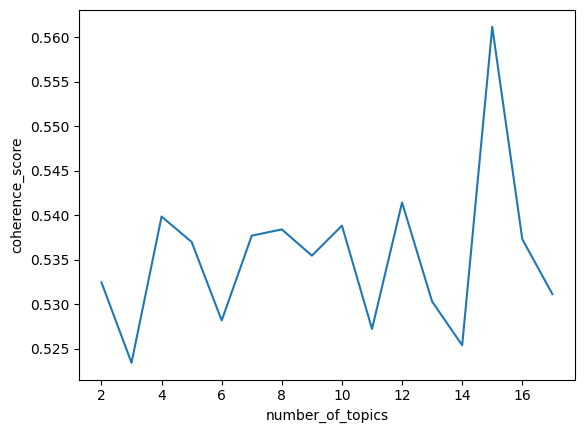

In [35]:
sns.lineplot(data=topic_coh_ges, x='number_of_topics', y='coherence_score')

In [36]:
lda_model_final = LdaMulticore(corpus, num_topics=15, id2word=dictionary, passes=10, workers=11)

2023-07-10 12:21:18,829 : INFO : using symmetric alpha at 0.06666666666666667
2023-07-10 12:21:18,830 : INFO : using symmetric eta at 0.06666666666666667
2023-07-10 12:21:18,844 : INFO : using serial LDA version on this node
2023-07-10 12:21:18,972 : INFO : running online LDA training, 15 topics, 10 passes over the supplied corpus of 334801 documents, updating every 22000 documents, evaluating every ~220000 documents, iterating 50x with a convergence threshold of 0.001000
2023-07-10 12:21:18,973 : INFO : training LDA model using 11 processes
2023-07-10 12:21:19,581 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/334801, outstanding queue size 1
2023-07-10 12:21:19,602 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/334801, outstanding queue size 2
2023-07-10 12:21:19,605 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/334801, outstanding queue size 3
2023-07-10 12:21:19,607 : INFO : PROGRESS: pass 0, dispatched chunk 

In [37]:
for idx, topic in lda_model_final.print_topics(-1):
    print('\nTopic: {} \nWords: {}'.format(idx, topic))

2023-07-10 12:25:06,165 : INFO : topic #0 (0.067): 0.087*"tip" + 0.030*"order" + 0.027*"ride" + 0.026*"eat" + 0.023*"delivery" + 0.018*"food" + 0.016*"take" + 0.015*"pay" + 0.013*"would" + 0.012*"customer"
2023-07-10 12:25:06,167 : INFO : topic #1 (0.067): 0.027*"drive" + 0.025*"make" + 0.024*"hour" + 0.024*"mile" + 0.022*"pay" + 0.018*"time" + 0.016*"week" + 0.015*"per" + 0.012*"gas" + 0.011*"trip"
2023-07-10 12:25:06,169 : INFO : topic #2 (0.067): 0.030*"ride" + 0.027*"minute" + 0.026*"cancel" + 0.021*"wait" + 0.018*"trip" + 0.017*"time" + 0.017*"pax" + 0.017*"go" + 0.014*"pick" + 0.013*"say"
2023-07-10 12:25:06,170 : INFO : topic #3 (0.067): 0.197*"not" + 0.127*"can" + 0.088*"do" + 0.012*"be" + 0.011*"say" + 0.010*"even" + 0.008*"know" + 0.008*"pax" + 0.008*"tell" + 0.008*"will"
2023-07-10 12:25:06,172 : INFO : topic #4 (0.067): 0.029*"like" + 0.024*"people" + 0.016*"would" + 0.014*"talk" + 0.013*"ask" + 0.012*"want" + 0.012*"say" + 0.010*"feel" + 0.009*"know" + 0.009*"think"
2023-0


Topic: 0 
Words: 0.087*"tip" + 0.030*"order" + 0.027*"ride" + 0.026*"eat" + 0.023*"delivery" + 0.018*"food" + 0.016*"take" + 0.015*"pay" + 0.013*"would" + 0.012*"customer"

Topic: 1 
Words: 0.027*"drive" + 0.025*"make" + 0.024*"hour" + 0.024*"mile" + 0.022*"pay" + 0.018*"time" + 0.016*"week" + 0.015*"per" + 0.012*"gas" + 0.011*"trip"

Topic: 2 
Words: 0.030*"ride" + 0.027*"minute" + 0.026*"cancel" + 0.021*"wait" + 0.018*"trip" + 0.017*"time" + 0.017*"pax" + 0.017*"go" + 0.014*"pick" + 0.013*"say"

Topic: 3 
Words: 0.197*"not" + 0.127*"can" + 0.088*"do" + 0.012*"be" + 0.011*"say" + 0.010*"even" + 0.008*"know" + 0.008*"pax" + 0.008*"tell" + 0.008*"will"

Topic: 4 
Words: 0.029*"like" + 0.024*"people" + 0.016*"would" + 0.014*"talk" + 0.013*"ask" + 0.012*"want" + 0.012*"say" + 0.010*"feel" + 0.009*"know" + 0.009*"think"

Topic: 5 
Words: 0.023*"post" + 0.022*"people" + 0.020*"shit" + 0.019*"fuck" + 0.017*"like" + 0.016*"make" + 0.015*"lol" + 0.012*"think" + 0.011*"fucking" + 0.010*"say"

